## Non-Jacobian Corrections to Auto-power (similar/same as Jalivan et al.)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *
%matplotlib inline

In [61]:
#general settings
LSST      = False
#if not LSST redhsift kernel
z0_1      = 1.
sigma_z_1 = 0.2
z0_2      = 1.0
sigma_z_2 = 0.2
bin_num1 = 'all'
bin_num2 = 'all'
zmax  = 2.5
bias  = 'simple'
chimax = chi_z(zmax)
print('zmax=%d'%zmax, 'chimax=%d'%chimax)


if LSST:
    file_ext = 'lsst_%s_%s'%(str(bin_num1), str(bin_num2))
else:
    file_ext = 'gaussgal_z0%d_%d_sigmaz%d_%d'%(z0_1*10,z0_2*10,sigma_z_1*10,sigma_z_2*10)
    
file_ext+=bias+'_bias'

file_ext+=  'zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print(file_ext, file_ext2)


params = {}
params['LSST']    = LSST
params['z01']     = z0_1
params['sigma_z1']= sigma_z_1
params['z02']     = z0_2
params['sigma_z2']= sigma_z_2
params['bin_num1']= bin_num1
params['bin_num2']= bin_num2
params['chimax']  = chimax
params['bias']    = bias
params['ext']     = file_ext
params['ext2']    = file_ext2

if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')


try:
    pickle.load(open('../settings/params_auto_%s.pkl'%file_ext,'rb'))
except:
    pickle.dump(params,open('../settings/params_auto_%s.pkl'%file_ext,'wb'))

zmax=2 chimax=4044
gaussgal_z010_10_sigmaz2_2simple_biaszmax25 zmax25


In [62]:
plotpath = '../plots/clgg_%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

In [63]:
if LSST:
    kernel1 = gal_clus(dNdz_LSST, bias_func, bin_num1)
    kernel2 = gal_clus(dNdz_LSST, bias_func, bin_num2)
else:
    kernel1 = gal_clus(Gauss_redshift(sigma_z=sigma_z_1,z0=z0_1), bias_func)
    kernel2 = gal_clus(Gauss_redshift(sigma_z=sigma_z_2,z0=z0_2), bias_func)

In [64]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

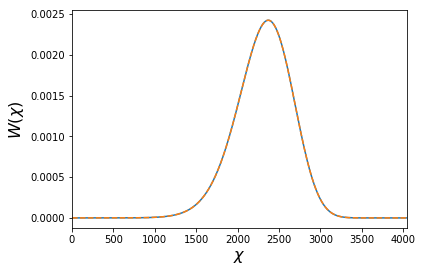

In [65]:
chis = np.linspace(1,chimax,20000)
plt.figure()
plt.plot(chis,kernel1(chis), label='kernel 1')
plt.plot(chis,kernel2(chis), label='kernel 2',ls='--')
plt.xlabel('$\chi$',fontsize=16)
plt.ylabel('$W(\chi)$',fontsize=16)
plt.xlim(0,chimax)
plt.savefig(plotpath+'redshiftkernels_%s.pdf'%file_ext, bbox_inches='tight')

In [66]:
### for harmonic space integrals
L   = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l   = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

### Auto Spectrum $C^{gg}(L)$

In [73]:
# auto spectrum
#clgg
try:
    ell_,Cl_gg= np.load('../output/cls/Clgg_%s.npy'%(file_ext))
except:
    begin=time.time()
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    n = 4
    chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I4_ltrc[ii])

    Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

    np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

    print('Time taken = ', time.time()-begin)

Time taken =  423.70028829574585


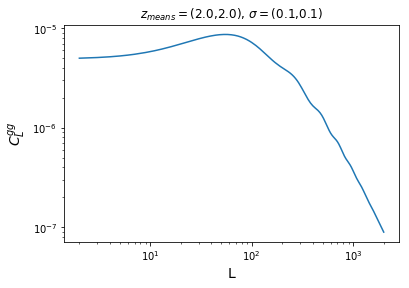

In [72]:
plt.figure()
plt.title('$z_{means}=$(%.1f,%.1f), $\sigma = $(%.1f,%.1f)'%(z0_1,z0_2,sigma_z_1,sigma_z_2))
plt.ylabel(r'$C_L^{gg}$', fontsize=14)
plt.xlabel('L', fontsize=14)
p=plt.loglog(ell_,Cl_gg)
plt.loglog(ell_,-Cl_gg,c=p[0].get_color(),ls='--')
plt.savefig(plotpath+'clgg_%s.pdf'%file_ext, bbox_inches='tight')
plt.show()

$Mgg22A = \int_0^{\chi_\max} d \chi_1 W^{(1)}_g(\chi_1)  \int_0^{\chi_\max} d \chi_2 \, W^{(2)}_g(\chi_2) C_l^{\delta \delta} (\chi_1, \chi_2) C_{|L-l|}^{\phi\phi}(\chi_1,\chi_2)$

In [70]:
# these files only depend on zmax, hence file_ext2 extension
chi1s, chi2s, clphiphirt         = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext2)
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext2)
clphiphirt                       = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t                 = np.swapaxes(clphiphir_over_t,1,2)

In [71]:
# this is cldeltadelta weighted by clphiphi, as it appears in the (2,2)-term
try: 
    _, Mgg22A = np.load('../M_matrices/Mgg22A_%s.npy'%file_ext)
    Mgg22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_       = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax      = ell_.size
        # phiphi should be second entry, associated with l (this is after variable trafo needed for evaluation)
        for ii  in range(ell_.size):        
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    print(time.time()-begin)

    Mgg22A = chimax*result*1./np.pi**2/2./4.
    np.save('../M_matrices/Mgg22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),Mgg22A])

    Mgg22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
422.6180582046509


$Mgg13a = \int_0^{\chi_\max} d \chi_1 \, W^{(1)}_g(\chi_1) \int_0^{\chi_\max} d \chi_2 \, W^{(2)}_g(\chi_2) C_L^{\delta \delta} (\chi_1, \chi_2) C_{l}^{\phi\phi}(\chi_1)$

In [ ]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]

In [ ]:
# this is cldeltadelta weighted by clphiphi(chi), as it appears in the (1,3a)-term
try:
    _, Mgg31a = np.load('../M_matrices/Mgg31a_%s.npy'%file_ext)
    _, Mgg31aA = np.load('../M_matrices/Mgg31aA_%s.npy'%file_ext)
    _, Mgg31aB = np.load('../M_matrices/Mgg31aB_%s.npy'%file_ext)
    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)
    Mgg31aA_spline = RectBivariateSpline(ell_,ell_,Mgg31aA)
    Mgg31aB_spline = RectBivariateSpline(ell_,ell_,Mgg31aB)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):   
            # phiphi should be second entry associated with l
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    Mgg31aA = chimax * result*1./np.pi**2/2./4.
    
    #and same again with exchanged kernels
    result = np.zeros((len(ell_),len(ell_)))  
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (kernel2(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel1(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (kernel1(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):   
            # phiphi should be second entry associated with l
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

        

        Mgg31aB = chimax * result*1./np.pi**2/2./4.
        
    print(time.time()-begin)
    
    Mgg31a= Mgg31aA+Mgg31aB

    np.save('../M_matrices/Mgg31a_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31a])
    np.save('../M_matrices/Mgg31aA_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31aA])
    np.save('../M_matrices/Mgg31aB_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31aB])

    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)
    Mgg31aA_spline = RectBivariateSpline(ell_,ell_,Mgg31aA)
    Mgg31aB_spline = RectBivariateSpline(ell_,ell_,Mgg31aB)

In [15]:
def get_regularized_sum_of_terms_1(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)-0.5*M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_2(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = - LL1*((LL*LL1*nu)**2-(LL*LL1*nu-LL1*LL1)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2*0.5
    return res

def get_Limber22_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(L_,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_Limber13_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1*nu)**2*M(LL,LL1,grid=False)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2*0.5*(-1)
    return res

In [16]:
#factor 0.5 from taylor expansion, also added in the draft and consistent with 2.13 in 21cm lensing paper
LimberTerms = get_regularized_sum_of_terms_1(L,l,phi,Mgg22A_spline,Mgg31a_spline,method='trapz')+get_regularized_sum_of_terms_2(L,l,phi,Mgg31a_spline,method='trapz')
LimberTerm13 = get_Limber13_term(L,l,phi,Mgg31a_spline,method='trapz')
LimberTerm22 = get_Limber22_term(L,l,phi,Mgg22A_spline,method='trapz')

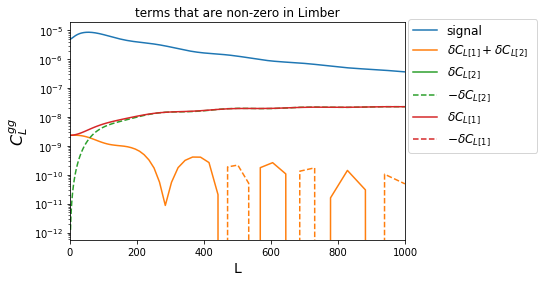

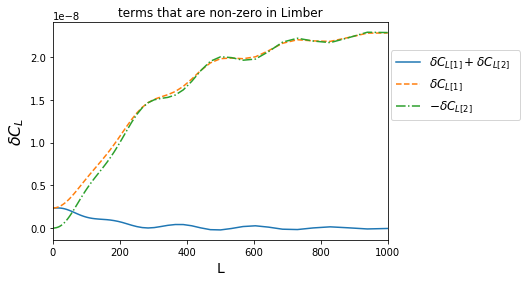

In [17]:
#maybe need to use second term to cancel other one? Or did we forget symmetrization in the cross??
plt.figure()
p=plt.plot(ell_,Cl_gg, label='signal')
plt.plot(ell_,-Cl_gg, c=p[0].get_color(), ls='--')
p=plt.plot(L,LimberTerms, label='$\delta C_{L[1]}+\delta C_{L[2]}$  ')
plt.plot(L,-LimberTerms,ls='--',c=p[0].get_color())
p=plt.plot(L,LimberTerm13,ls='-',label='$\delta C_{L[2]}$  ')
plt.plot(L,-LimberTerm13,ls='--',c=p[0].get_color(),label='$-\delta C_{L[2]}$  ')
p=plt.plot(L,LimberTerm22,ls='-',label='$\delta C_{L[1]}$ ')
plt.plot(L,-LimberTerm22,ls='--',c=p[0].get_color(),label='$-\delta C_{L[1]}$ ')
plt.yscale('log')
plt.legend(loc=(1.01,0.4),fontsize=12)
plt.title('terms that are non-zero in Limber')
plt.xlim(1,max(L))
plt.xlabel('L',fontsize=14)
plt.ylabel('$C_L^{gg}$',fontsize=16)
plt.savefig('../plots/Limberterms_%s.pdf'%file_ext, bbox_inches='tight')


plt.figure()
plt.plot(L,LimberTerms, label='$\delta C_{L[1]}+\delta C_{L[2]}$  ')
plt.plot(L,LimberTerm22,ls='--',label='$\delta C_{L[1]}$ ')
plt.plot(L,-LimberTerm13,ls='-.',label='$-\delta C_{L[2]}$  ')
plt.legend(loc=(1.01,0.55),fontsize=12)
plt.title('terms that are non-zero in Limber')
plt.xlim(1,max(L))
plt.xlabel('L',fontsize=14)
plt.ylabel('$\delta C_L$',fontsize=16)
plt.savefig('../plots/Limberterms_%s_lin.pdf'%file_ext, bbox_inches='tight')

$C_{22}^{(g g)}(L)  = \int_0^{\chi_\max} d \chi_1 \, W^{(1)}_g(\chi_1)  \int_0^{\chi_\max} d \chi_2 \, W^{(2)}_g(\chi_2) C_l^{\delta \phi}(\chi_1, \chi_2) C_{|L-l|}^{\delta\phi}(\chi_2,\chi_1)$

In [18]:
# get cldeltaphi for second <22> term
# same as old code
try:
    #assert(False)
    clphidelta = np.load('../G_matrices/clphidelta_%s.npy'%file_ext2)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2  = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))
        chi2fac00 = (D_chi(r2d*t2d*chimax2)*(1+z_chi(r2d*t2d*chimax2))*inner_kernel(r2d*t2d*chimax2, chimax1))
        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01
        
        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*-2 #no chimax because not summing over r, -2 for psi-> phi

    clphidelta = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, delta goes as r2d
    np.save('../G_matrices/clphidelta_%s'%file_ext2,clphidelta)
    
# phi goes as r2d
cldeltaphi = np.swapaxes(clphidelta,1,2)

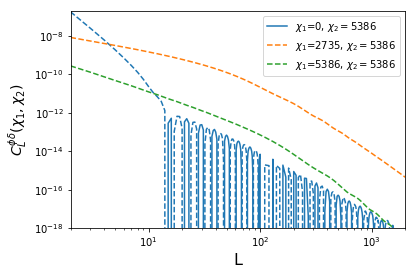

In [19]:
plt.figure()
p = plt.loglog(ell_, cldeltaphi[:,0,-1], label='$\chi_1$=%d, $\chi_2=%d$'%(t_[0]*chimax,t_[-1]*chimax))
plt.loglog(ell_, -cldeltaphi[:,0,-1], ls='--',color=p[0].get_color())
plt.loglog(ell_, -cldeltaphi[:,50,-1],ls='--', label='$\chi_1$=%d, $\chi_2=%d$'%(t_[50]*chimax,t_[-1]*chimax))
plt.loglog(ell_, -cldeltaphi[:,-1,-1],ls='--', label='$\chi_1$=%d, $\chi_2=%d$'%(t_[-1]*chimax,t_[-1]*chimax))
plt.ylabel('$C_L^{\phi\delta}(\chi_1,\chi_2)$', fontsize=14)
plt.xlabel('L',fontsize=16)
plt.ylim(1e-18,2e-7)
plt.xlim(ell_.min(),ell_.max())
plt.legend()
plt.show()

In [20]:
# this is the second term in <2,2>
try:
    _ , Mgg22B = np.load('../M_matrices/Mgg22B_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is |L-l|, clphidelta-> delta goes as r2d, goes with kernel2 -> goes with L-l
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[jj]*clphidelta[ii])
    result*=chimax**2/4.

    Mgg22B = result

    # first index is L
    np.save('../M_matrices/Mgg22B_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg22B])

Mgg22B_spline = RectBivariateSpline(ell_,ell_,Mgg22B)

$Mgg31b = \int_0^{\chi_\max} d \chi_1 \, W^{(1)}_g(\chi_1) \int_0^{\chi_\max} d \chi_2 \, W^{(2)}_g(\chi_2)
\int_0^{\chi_1} d \chi_1' \, W(\chi_1',\chi_1) C_l^{\delta \phi} (\chi_1, \chi_1') C_{L}^{\Psi\delta}(\chi_1',\chi_2)+symm $

In [21]:
#integral over last CL
clpsigal1, chis = np.load('../G_matrices/clpsigal_kernel1%s.npy'%file_ext)
clpsigal2, chis = np.load('../G_matrices/clpsigal_kernel2%s.npy'%file_ext)
#first entry is phi
clphidelta, chimaxs = np.load('../G_matrices/clphidelta_paralleli_M31b_%s.npy'%file_ext)

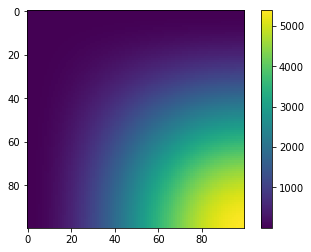

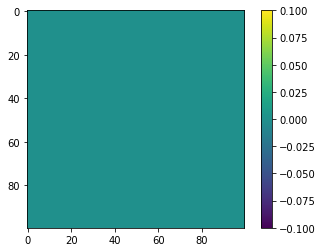

In [22]:
plt.imshow(chimaxs)
plt.colorbar()
plt.show()
r2d, t2d = np.meshgrid(t_,t_)
plt.imshow(r2d*t2d*chimax-chimaxs)
plt.colorbar()

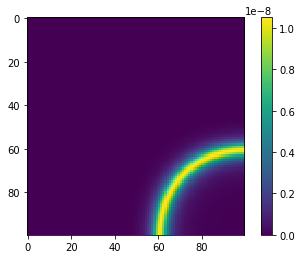

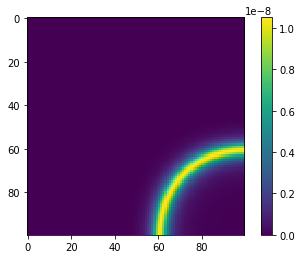

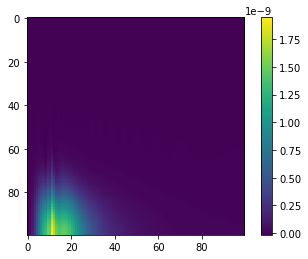

In [23]:
# I expect this to be symmetric -> which it is!
plt.imshow(clpsigal1[10])
plt.colorbar()
plt.show()
plt.imshow(clpsigal2[10])
plt.colorbar()
plt.show()
plt.imshow(clphidelta[10])
plt.colorbar()

In [24]:
# this is the first term in <3, 1 b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    _ , Mgg31b = np.load('../M_matrices/Mgg31b_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel1(r2d*chimax)*clphidelta[jj].T*clpsigal2[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression

    Mgg31b = result

    # first index is L
    np.save('../M_matrices/Mgg31b_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31b])

Mgg31b_spline = RectBivariateSpline(ell_,ell_,Mgg31b)

In [25]:
# this is the first term in <1, 3 b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    _ , Mgg13b = np.load('../M_matrices/Mgg13b_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel2(r2d*chimax)*clphidelta[jj].T*clpsigal1[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression

    Mgg13b = result

    # first index is L
    np.save('../M_matrices/Mgg13b_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg13b])

Mgg13b_spline = RectBivariateSpline(ell_,ell_,Mgg13b)

In [26]:
Mgg13b_spline_sym = RectBivariateSpline(ell_,ell_,Mgg13b+Mgg31b)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


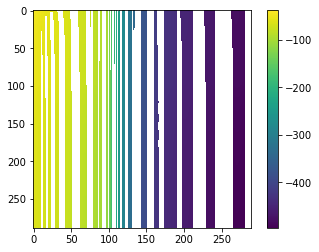

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


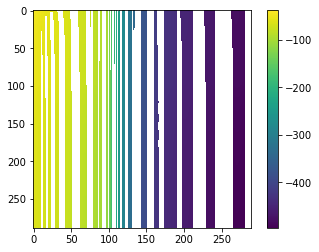

In [27]:
plt.imshow(np.log(Mgg13b))
plt.colorbar()
plt.show()
plt.imshow(np.log(Mgg31b))
plt.colorbar()

In [40]:
def get_regularized_sum_of_terms_11(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)+M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_22(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*((LL*LL1*nu)**2-(LL*LL1*nu-LL1*LL1)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_noLimber22_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(L_,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

#gives same result, because of symmetry
def get_noLimber22_term2(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(LL1,L_,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_noLimber13_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1*nu)**2*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [41]:
NoLimberTerms = get_regularized_sum_of_terms_11(L,l,phi,Mgg22B_spline,Mgg13b_spline_sym,method='trapz')+get_regularized_sum_of_terms_22(L,l,phi,Mgg13b_spline_sym,method='trapz')
NoLimberTerm1 = get_noLimber22_term(L,l,phi,Mgg22B_spline)
NoLimberTerm_ = get_noLimber22_term2(L,l,phi,Mgg22B_spline)
NoLimberTerm2 = get_noLimber13_term(L,l,phi,Mgg13b_spline_sym)
NoLimberTerm_ = get_noLimber13_term2(L,l,phi,Mgg13b_spline_sym)

In [30]:
NoLimberTerm2a = get_noLimber13_term(L,l,phi,Mgg13b_spline)
NoLimberTerm2b = get_noLimber13_term(L,l,phi,Mgg31b_spline)

### additionally there's also magnification bias
$-\frac{1}{2}(5(s-0.4)) \int^{\chi_{max}}_0 d \chi_1 W^{(1)}(\chi_1) \int^{\chi_{max}}_0 d \chi_2 W^{(2)}(\chi_2) C_L^{\delta\phi}+ symm$ 

In [31]:
s=0.6

try:
    assert(False)
    _ , Mggbias = np.load('../M_matrices/Mggbias_s%d_%s.npy'%(10*s,file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_)))
    for ii in range(len(ell_)):
        result[ii] = np.sum(w11*w12*(kernel1(t2d*r2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[ii]+kernel2(t2d*r2d*chimax)*kernel1(r2d*chimax)*cldeltaphi[ii]))
    result*=chimax**2/4.*(-0.5)*(5*(s-0.4))
                           
    Mggbias = result

    # first index is L
    np.save('../M_matrices/Mggbias_s%d_%s.npy'%(10*s,file_ext),[np.meshgrid(ell_),Mggbias])

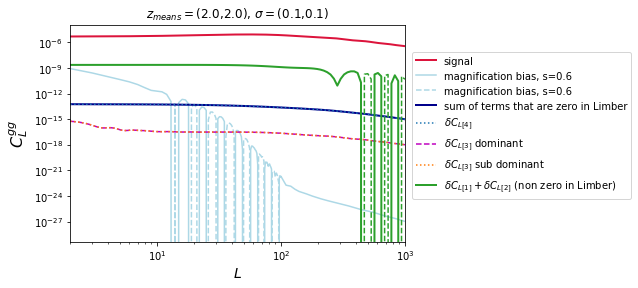

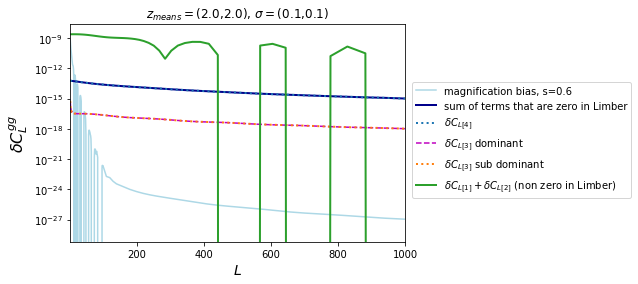

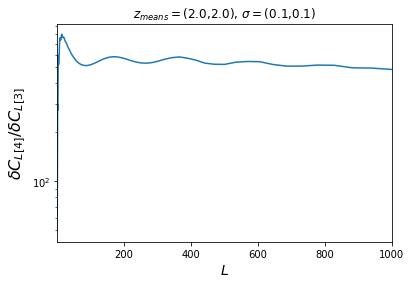

In [45]:
# doing cancellation trick does not seem important here, however, the delta deltaC_3 term (red) seems subdominant for this redshift combination
#as they notice correctly, one is subdominant
plt.figure()
plt.title('$z_{means}=$(%.1f,%.1f), $\sigma = $(%.1f,%.1f)'%(z0_1,z0_2,sigma_z_1,sigma_z_2))
plt.plot(ell_,Cl_gg, label='signal', color='crimson', lw=2)
plt.plot(ell_,-Cl_gg, ls='--', color='crimson', lw=2)
plt.plot(ell_,Mggbias, label='magnification bias, s=%.1f'%s, c='lightblue',lw=1.5)
plt.plot(ell_,-Mggbias, label='magnification bias, s=%.1f'%s,ls='--', c='lightblue',lw=1.5)
plt.plot(L,NoLimberTerms,ls='-', label='sum of terms that are zero in Limber', lw='2', c='darkblue')
plt.plot(L,NoLimberTerm1,ls=':',label='$\delta C_{L[4]}$')
#plt.plot(L,NoLimberTerm2,ls='-.',label='13 no Limber')
plt.plot(L,NoLimberTerm2a,ls='--',label='$\delta C_{L[3]}$ dominant', c='m')
plt.plot(L,NoLimberTerm2b,ls=':',label='$\delta C_{L[3]}$ sub dominant')
#plt.plot(L,(NoLimberTerm2+NoLimberTerm1),ls=':',color='darkblue',label='no Limber terms, added')

#plt.plot(L,-LimberTerm13,ls='--',label='13 Limber')
#plt.plot(L,LimberTerm22,ls='-.',label='')
p=plt.plot(L,LimberTerms, lw=2, label='$\delta C_{L[1]}+\delta C_{L[2]}$ (non zero in Limber)')
plt.plot(L,-LimberTerms,ls='--',c=p[0].get_color())
#plt.plot(L,(LimberTerm22+LimberTerm13),ls=':',color='m',label='Limber, added')
plt.ylabel('$C_L^{gg}$',fontsize=16)
plt.xlabel('$L$',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=(1.02,0.2))
plt.xlim(2,max(L))
plt.savefig('../plots/corrections_on_auto_%s.pdf'%file_ext, bbox_inches='tight')


plt.figure()
plt.title('$z_{means}=$(%.1f,%.1f), $\sigma = $(%.1f,%.1f)'%(z0_1,z0_2,sigma_z_1,sigma_z_2))
plt.plot(ell_,Mggbias, label='magnification bias, s=%.1f'%s, c='lightblue',lw=1.5)
plt.plot(L,NoLimberTerms,ls='-', label='sum of terms that are zero in Limber', lw='2', c='darkblue')
plt.plot(L,NoLimberTerm1,ls=':',label='$\delta C_{L[4]}$',lw=2)
plt.plot(L,NoLimberTerm2a,ls='--',label='$\delta C_{L[3]}$ dominant', c='m')
plt.plot(L,NoLimberTerm2b,ls=':',label='$\delta C_{L[3]}$ sub dominant',lw=2)
p=plt.plot(L,LimberTerms, lw=2, label='$\delta C_{L[1]}+\delta C_{L[2]}$ (non zero in Limber)')
plt.ylabel('$\delta C_L^{gg}$',fontsize=16)
plt.xlabel('$L$',fontsize=14)
plt.legend(loc=(1.02,0.2))
plt.xlim(2,max(L))
plt.yscale('log')
plt.savefig('../plots/corrections_on_auto_%s_lin.pdf'%file_ext, bbox_inches='tight')


plt.figure()
plt.title('$z_{means}=$(%.1f,%.1f), $\sigma = $(%.1f,%.1f)'%(z0_1,z0_2,sigma_z_1,sigma_z_2))
plt.plot(L,NoLimberTerm1/(NoLimberTerm2b+NoLimberTerm2a),ls='-')
plt.ylabel('$\delta C_{L[4]}/\delta C_{L[3]}$',fontsize=16)
plt.xlabel('$L$',fontsize=14)
plt.xlim(2,max(L))
plt.yscale('log')
plt.savefig('../plots/dCl4_over_dCl3_%s.pdf'%file_ext, bbox_inches='tight')

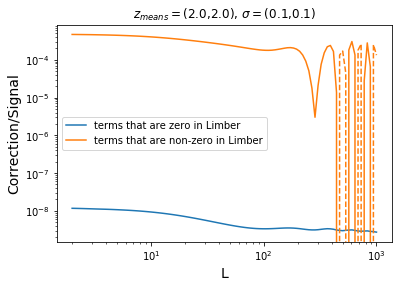

In [46]:
plt.figure()
plt.title('$z_{means}=$(%.1f,%.1f), $\sigma = $(%.1f,%.1f)'%(z0_1,z0_2,sigma_z_1,sigma_z_2))
p=plt.loglog(L, NoLimberTerms/np.interp(L,ell_,Cl_gg), label='terms that are zero in Limber')
plt.loglog(L, -NoLimberTerms/np.interp(L,ell_,Cl_gg), ls='--',c= p[0].get_color())
p=plt.loglog(L, LimberTerms/np.interp(L,ell_,Cl_gg), label='terms that are non-zero in Limber')
plt.loglog(L, -LimberTerms/np.interp(L,ell_,Cl_gg), ls='--',c= p[0].get_color())
plt.ylabel('Correction/Signal',fontsize=14)
plt.xlabel('L',fontsize=14)
plt.legend(loc='best')
plt.savefig('../plots/corrections_on_auto_relative_%s.pdf'%file_ext, bbox_inches='tight')